# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load YS DC progenitor

In [4]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/liver/data/ys_total_annotation_20191127.h5ad")

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
DC progenitor                78
Early mast cell             133
Endothelium                 160
Erythroid AB                892
Erythroid EZ               1167
Erythroid M                 275
ILC precursor                25
Lymphoid progenitor         184
MEMP                        121
Monocyte                     38
Myeloid progenitor           61
NK early                     50
yolk sac Macrophage I      3063
yolk sac Macrophage II     3619
yolk sac progenitor/MPP     205
dtype: int64

In [7]:
cell_numbers = adata.obs.groupby(["cell.labels_progen"]).apply(len)
cell_numbers

cell.labels_progen
CMP                    55
ELP                   174
GMP                    40
HSC                   105
MEMP                   55
MEP                    56
Monocyte precursor     26
macrophage             42
neut myeloid           18
dtype: int64

In [8]:
annotation = pd.DataFrame(adata.obs["cell.labels"])
progen_annotation = pd.DataFrame(adata.obs["cell.labels_progen"])
progen_annotation["cell.labels"] = progen_annotation["cell.labels_progen"]
annotation.update(progen_annotation)

cell_numbers = annotation.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP                         55
DC progenitor               78
ELP                        174
Early mast cell            133
Endothelium                160
Erythroid AB               892
Erythroid EZ              1167
Erythroid M                275
GMP                         40
HSC                        105
ILC precursor               25
MEMP                        55
MEP                         56
Monocyte                    38
Monocyte precursor          26
NK early                    50
macrophage                  42
neut myeloid                18
yolk sac Macrophage I     3063
yolk sac Macrophage II    3619
dtype: int64

In [9]:
adata.obs["new_cell.labels"] = annotation
cell_numbers = adata.obs.groupby(["new_cell.labels"]).apply(len)
cell_numbers

new_cell.labels
CMP                         55
DC progenitor               78
ELP                        174
Early mast cell            133
Endothelium                160
Erythroid AB               892
Erythroid EZ              1167
Erythroid M                275
GMP                         40
HSC                        105
ILC precursor               25
MEMP                        55
MEP                         56
Monocyte                    38
Monocyte precursor          26
NK early                    50
macrophage                  42
neut myeloid                18
yolk sac Macrophage I     3063
yolk sac Macrophage II    3619
dtype: int64

# Pre-process the dataset

In [10]:
# normalise count data 
sc.pp.normalize_total(adata)

In [11]:
# log the count data 
sc.pp.log1p(adata)

In [12]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [13]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [14]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Run DEGs

In [15]:
# run degs on normalised and logged data (saved as adata.raw), not on additionally scaled data (saved as adata.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata, groupby='new_cell.labels', method='wilcoxon', use_raw=False, log_transformed=True, genes=500)

... storing 'new_cell.labels' as categorical


In [16]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25, use_raw=False)

In [17]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/ys_overall_degs_20200726.csv")
degs_by_cluster[:10]

,CMP_n,CMP_l,DC progenitor_n,DC progenitor_l,ELP_n,ELP_l,Early mast cell_n,Early mast cell_l,Endothelium_n,Endothelium_l,Erythroid AB_n,Erythroid AB_l,Erythroid EZ_n,Erythroid EZ_l,Erythroid M_n,Erythroid M_l,GMP_n,GMP_l,HSC_n,HSC_l,ILC precursor_n,ILC precursor_l,MEMP_n,MEMP_l,MEP_n,MEP_l,Monocyte_n,Monocyte_l,Monocyte precursor_n,Monocyte precursor_l,NK early_n,NK early_l,macrophage_n,macrophage_l,neut myeloid_n,neut myeloid_l,yolk sac Macrophage I_n,yolk sac Macrophage I_l,yolk sac Macrophage II_n,yolk sac Macrophage II_l
0,RPS3,2.966084,RPSA,2.630184,LSP1,6.623803,MT-CO1,4.707962,RAMP2,13.078521,HBA2,3.895469,GYPB,5.216068,SLC25A37,4.043734,RPS17,2.424065,RPS3,3.036032,CD52,8.219834,RP11-620J15.3,7.733655,MT-ND4,5.524509,S100A8,7.911853,LYZ,13.473810,B2M,2.239950,LSP1,5.352328,AZU1,17.840763,FTL,1.999538,TTR,4.290329
1,RPS6,2.730059,RPS2,2.289211,RPL3,2.751245,MT-ND3,6.716312,NGFRAP1,6.113627,HBA1,3.781796,HBZ,4.175175,HBG2,3.488054,RPS2,2.535852,RPS14,2.418968,MT-CO1,5.066951,HNRNPA1,3.596772,MT-ND2,6.397603,LYZ,8.121016,FCN1,15.395452,HLA-B,3.400120,CD74,3.828150,MPO,17.114401,ATP5E,2.128402,APOA2,4.332725
2,RPS3A,2.801552,RPLP0,2.401653,RPSA,2.730648,MT-ATP6,5.515584,TFPI,9.267145,HBG2,3.986333,HBE1,4.186734,ALAS2,4.353496,RPSA,2.894451,RPS3A,2.907670,PABPC1,4.748269,NPM1,3.302345,MT-CO3,5.091118,S100A6,3.567663,S100A8,12.026727,RPS27,2.123353,RPL7,2.232366,LYZ,13.714253,CSTB,1.934200,APOA1,4.121416
3,RPS14,2.276238,RPS5,2.389503,RPS3,2.506240,MT-ND4,5.497644,S100A16,12.363203,SNCA,5.089516,PRDX2,4.776512,SLC4A1,5.498359,RPL37A,1.953860,RPL10A,3.019260,RPL13,2.464969,RPL7,2.833500,MT-ND1,6.829681,S100A9,3.325827,MNDA,12.175335,NKG7,8.953541,NPM1,2.457752,RP11-1143G9.4,14.924234,SH3BGRL3,1.718599,APOC3,4.285583
4,RPL9,2.282358,RPL8,1.867290,NPM1,3.093770,MT-CYB,6.074019,GNG11,9.471772,AC104389.1,4.437877,GYPA,4.776487,SNCA,4.243222,RPS12,2.147299,RPS18,2.435081,RPL10,2.369725,RPS4X,2.782777,MT-CYB,6.004796,FCN1,12.269789,S100A9,4.900815,HLA-A,3.636760,RPL3,2.231373,RPLP1,2.727044,CTSB,2.027651,AFP,3.947747
5,RPL32,2.121164,RPL29,2.085427,RPS4X,2.536516,MT-CO2,5.083335,VAMP5,8.470659,BPGM,5.413613,MT1G,4.839268,AC104389.1,3.880338,RPS3,2.651342,RPL18A,2.731695,RPS27,2.534204,RPS6,2.573049,MT-ND5,6.573544,TSPO,3.754257,S100A12,13.114463,HLA-C,3.304679,JAML,4.701021,RPLP2,2.530638,CTSD,2.101517,AHSG,4.279569
6,RPS18,2.284274,RPS3,2.265752,RPS5,2.510851,MT-CO3,5.065472,MARCKSL1,7.933271,HBG1,3.738980,AHSP,4.290276,DONSON,4.969353,RPL18A,2.378480,RPL7,3.105773,MT-CYB,6.458712,RPL3,2.922347,MT-CO1,4.275725,MNDA,7.250645,CSTA,12.178555,RPL13,1.604803,RPS5,2.118678,RPS14,2.464887,TYROBP,1.612518,SERPINA1,3.856454
7,RPS5,2.789206,RPL3,2.449908,RPL18,2.260664,EEF1A1,2.795485,TM4SF1,14.042605,SLC25A37,3.534975,MT2A,4.241272,HBM,4.869617,RPLP1,1.873568,RPS6,2.835218,TRBC1,17.359806,RPS18,2.213470,MT-CO2,4.698860,SRGN,2.335105,TSPO,6.120769,RPL10,1.665098,HNRNPA1,2.530588,RPL13,2.331445,TMSB4X,1.261381,APOM,4.143858
8,RPL18A,2.563469,RPL18A,2.004643,RPLP0,2.553741,EIF3E,3.798067,ECSCR.1,14.650933,HBB,6.945065,MT1E,4.727218,HBB,5.196047,RPL14,2.550406,RPL3,3.156283,MT-CO2,5.096884,RPL5,2.930053,MT-ND3,5.410388,VCAN,7.521479,S100A6,3.713937,IL2RG,7.282015,RPLP0,2.185049,RPL39,2.541706,ATP5I,1.859129,RBP4,4.318085
9,RPS2,2.567080,RPS7,2.126231,RPLP1,1.778055,RPL10,2.103831,CRIP2,13.439416,ALAS2,3.782628,MT1F,4.524157,HBA1,3.171838,RPLP0,2.613875,RPL29,2.633642,MT-CO3,5.222178,RPS3,2.607135,MT-ATP6,4.823247,HLA-B,2.536402,RP11-1143G9.4,12.860749,RPL23A,1.915320,RPSA,2.301512,SRGN,3.731056,HBZ,0.919247,CST3,2.261660


In [18]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/ys_overall_degs_filtered_20200726.csv")
degs_by_cluster_filtered[:10]

,CMP_n,CMP_l,DC progenitor_n,DC progenitor_l,ELP_n,ELP_l,Early mast cell_n,Early mast cell_l,Endothelium_n,Endothelium_l,Erythroid AB_n,Erythroid AB_l,Erythroid EZ_n,Erythroid EZ_l,Erythroid M_n,Erythroid M_l,GMP_n,GMP_l,HSC_n,HSC_l,ILC precursor_n,ILC precursor_l,MEMP_n,MEMP_l,MEP_n,MEP_l,Monocyte_n,Monocyte_l,Monocyte precursor_n,Monocyte precursor_l,NK early_n,NK early_l,macrophage_n,macrophage_l,neut myeloid_n,neut myeloid_l,yolk sac Macrophage I_n,yolk sac Macrophage I_l,yolk sac Macrophage II_n,yolk sac Macrophage II_l
0,NaN,2.966084,NaN,2.630184,LSP1,6.623803,MT-CO1,4.707962,RAMP2,13.078521,NaN,3.895469,GYPB,5.216068,SLC25A37,4.043734,NaN,2.424065,NaN,3.036032,CD52,8.219834,RP11-620J15.3,7.733655,MT-ND4,5.524509,S100A8,7.911853,LYZ,13.473810,NaN,2.239950,LSP1,5.352328,AZU1,17.840763,FTL,1.999538,TTR,4.290329
1,NaN,2.730059,NaN,2.289211,NaN,2.751245,MT-ND3,6.716312,NGFRAP1,6.113627,NaN,3.781796,HBZ,4.175175,NaN,3.488054,NaN,2.535852,NaN,2.418968,MT-CO1,5.066951,NaN,3.596772,MT-ND2,6.397603,LYZ,8.121016,FCN1,15.395452,HLA-B,3.400120,CD74,3.828150,MPO,17.114401,ATP5E,2.128402,APOA2,4.332725
2,NaN,2.801552,NaN,2.401653,NaN,2.730648,MT-ATP6,5.515584,TFPI,9.267145,NaN,3.986333,HBE1,4.186734,ALAS2,4.353496,NaN,2.894451,NaN,2.907670,NaN,4.748269,NaN,3.302345,MT-CO3,5.091118,S100A6,3.567663,S100A8,12.026727,NaN,2.123353,NaN,2.232366,LYZ,13.714253,CSTB,1.934200,APOA1,4.121416
3,NaN,2.276238,NaN,2.389503,NaN,2.506240,MT-ND4,5.497644,S100A16,12.363203,SNCA,5.089516,PRDX2,4.776512,SLC4A1,5.498359,NaN,1.953860,NaN,3.019260,NaN,2.464969,NaN,2.833500,MT-ND1,6.829681,NaN,3.325827,MNDA,12.175335,NKG7,8.953541,NaN,2.457752,RP11-1143G9.4,14.924234,SH3BGRL3,1.718599,APOC3,4.285583
4,NaN,2.282358,NaN,1.867290,NaN,3.093770,MT-CYB,6.074019,GNG11,9.471772,AC104389.1,4.437877,GYPA,4.776487,SNCA,4.243222,NaN,2.147299,NaN,2.435081,NaN,2.369725,NaN,2.782777,MT-CYB,6.004796,FCN1,12.269789,NaN,4.900815,HLA-A,3.636760,NaN,2.231373,NaN,2.727044,CTSB,2.027651,AFP,3.947747
5,NaN,2.121164,NaN,2.085427,NaN,2.536516,MT-CO2,5.083335,VAMP5,8.470659,BPGM,5.413613,MT1G,4.839268,AC104389.1,3.880338,NaN,2.651342,NaN,2.731695,NaN,2.534204,NaN,2.573049,MT-ND5,6.573544,TSPO,3.754257,S100A12,13.114463,NaN,3.304679,JAML,4.701021,NaN,2.530638,CTSD,2.101517,AHSG,4.279569
6,NaN,2.284274,NaN,2.265752,NaN,2.510851,MT-CO3,5.065472,MARCKSL1,7.933271,HBG1,3.738980,AHSP,4.290276,DONSON,4.969353,NaN,2.378480,NaN,3.105773,MT-CYB,6.458712,NaN,2.922347,MT-CO1,4.275725,MNDA,7.250645,CSTA,12.178555,NaN,1.604803,NaN,2.118678,NaN,2.464887,NaN,1.612518,SERPINA1,3.856454
7,NaN,2.789206,NaN,2.449908,NaN,2.260664,NaN,2.795485,TM4SF1,14.042605,SLC25A37,3.534975,MT2A,4.241272,HBM,4.869617,NaN,1.873568,NaN,2.835218,TRBC1,17.359806,NaN,2.213470,MT-CO2,4.698860,NaN,2.335105,TSPO,6.120769,NaN,1.665098,NaN,2.530588,NaN,2.331445,NaN,1.261381,APOM,4.143858
8,NaN,2.563469,NaN,2.004643,NaN,2.553741,EIF3E,3.798067,ECSCR.1,14.650933,HBB,6.945065,MT1E,4.727218,HBB,5.196047,NaN,2.550406,NaN,3.156283,MT-CO2,5.096884,NaN,2.930053,MT-ND3,5.410388,VCAN,7.521479,S100A6,3.713937,IL2RG,7.282015,NaN,2.185049,NaN,2.541706,ATP5I,1.859129,RBP4,4.318085
9,NaN,2.567080,NaN,2.126231,NaN,1.778055,NaN,2.103831,CRIP2,13.439416,ALAS2,3.782628,MT1F,4.524157,NaN,3.171838,NaN,2.613875,NaN,2.633642,MT-CO3,5.222178,NaN,2.607135,MT-ATP6,4.823247,HLA-B,2.536402,RP11-1143G9.4,12.860749,NaN,1.915320,NaN,2.301512,NaN,3.731056,HBZ,0.919247,CST3,2.261660


# Save the metadata

In [19]:
pd.DataFrame(adata.obs["new_cell.labels"]).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/ys_overall_annot_20200726.csv")

# Save the data

In [20]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [21]:
adata.X

<10071x32084 sparse matrix of type '<class 'numpy.float32'>'
	with 20760653 stored elements in Compressed Sparse Row format>

In [22]:
adata.raw.X

<10071x32084 sparse matrix of type '<class 'numpy.float32'>'
	with 23023634 stored elements in Compressed Sparse Row format>

In [23]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/ys_dc_progenitor_degs_20200727.h5ad")

# Reload the data and run dotplots

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/ys_dc_progenitor_degs_20200727.h5ad")

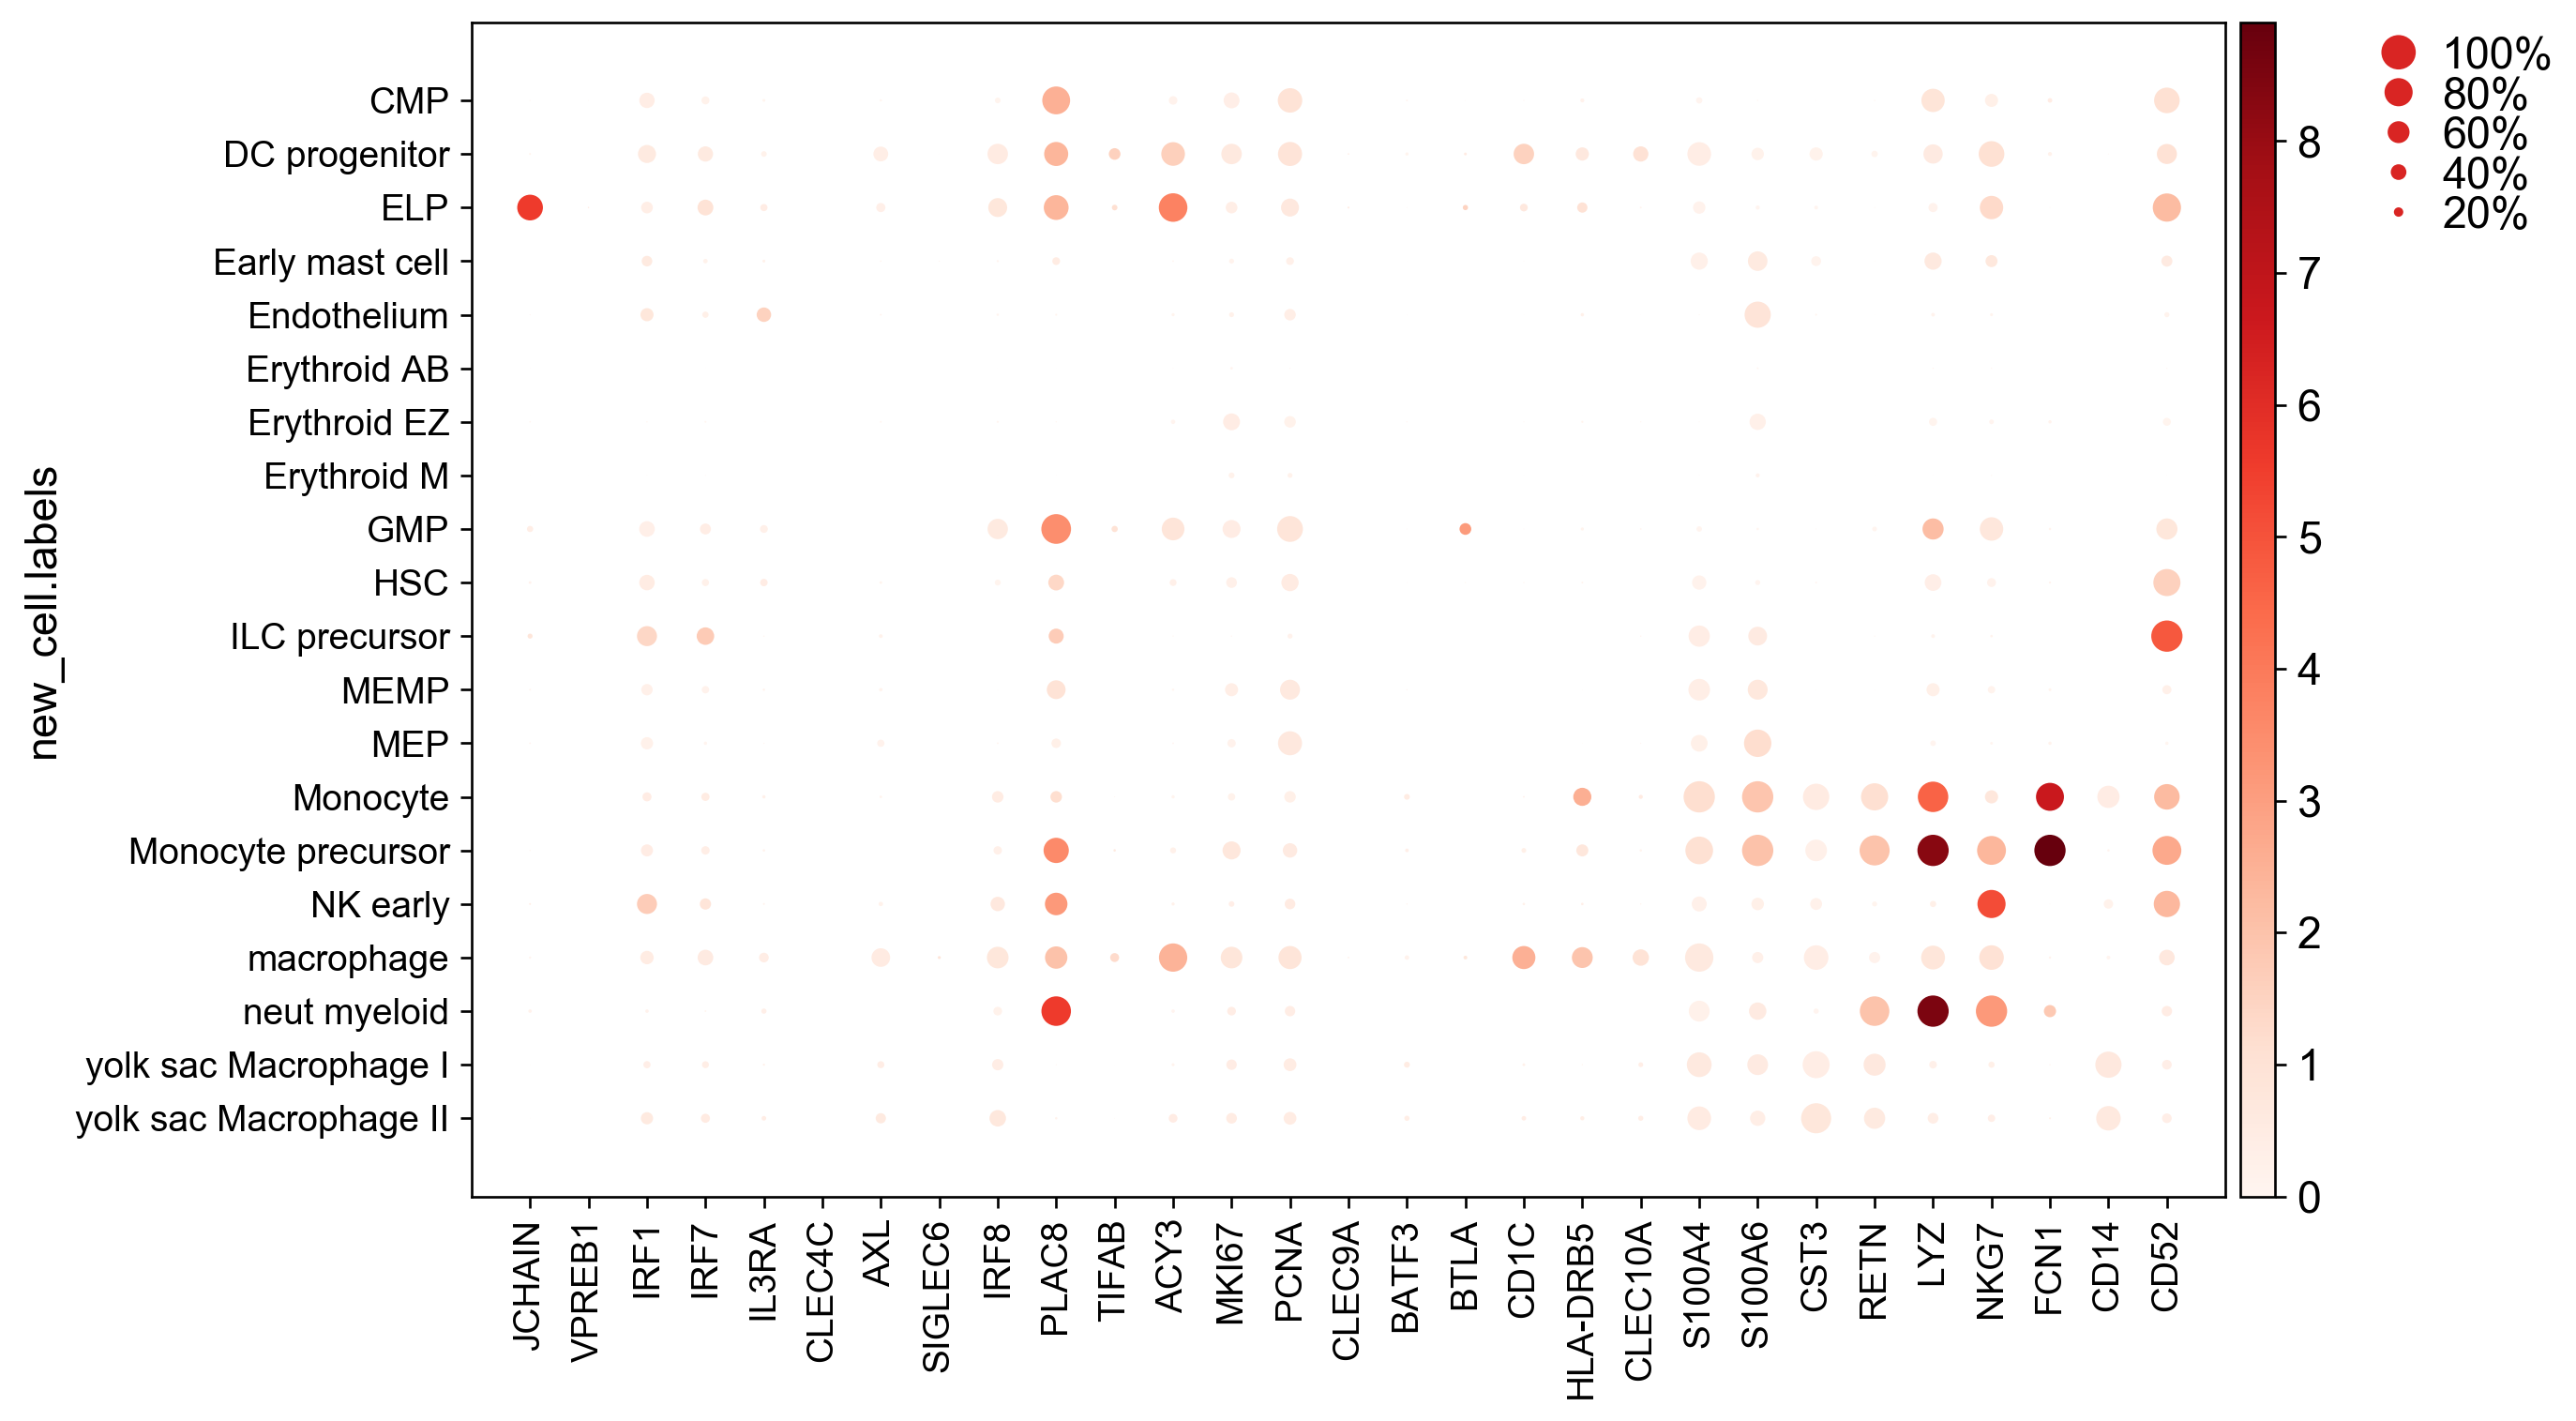

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[10.149999999999999, 0, 0.2, 0.5, 0.25])

In [4]:
genes = ['JCHAIN', 'VPREB1', 'IRF1', 'IRF7', 'IL3RA', 'CLEC4C', 'AXL', 'SIGLEC6', 'IRF8', 'PLAC8', 'TIFAB', 'ACY3',
'MKI67', 'PCNA', 'CLEC9A', 'BATF3', 'BTLA', 'CD1C', 'HLA-DRB5', 'CLEC10A', 'S100A4', 'S100A6', 'CST3', 'RETN', 
'LYZ', 'NKG7', 'FCN1', 'CD14', 'CD52']

sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.dotplot(adata, var_names=genes, groupby="new_cell.labels", use_raw=False, save="ys_fig2a_dotplot_20200727.pdf")

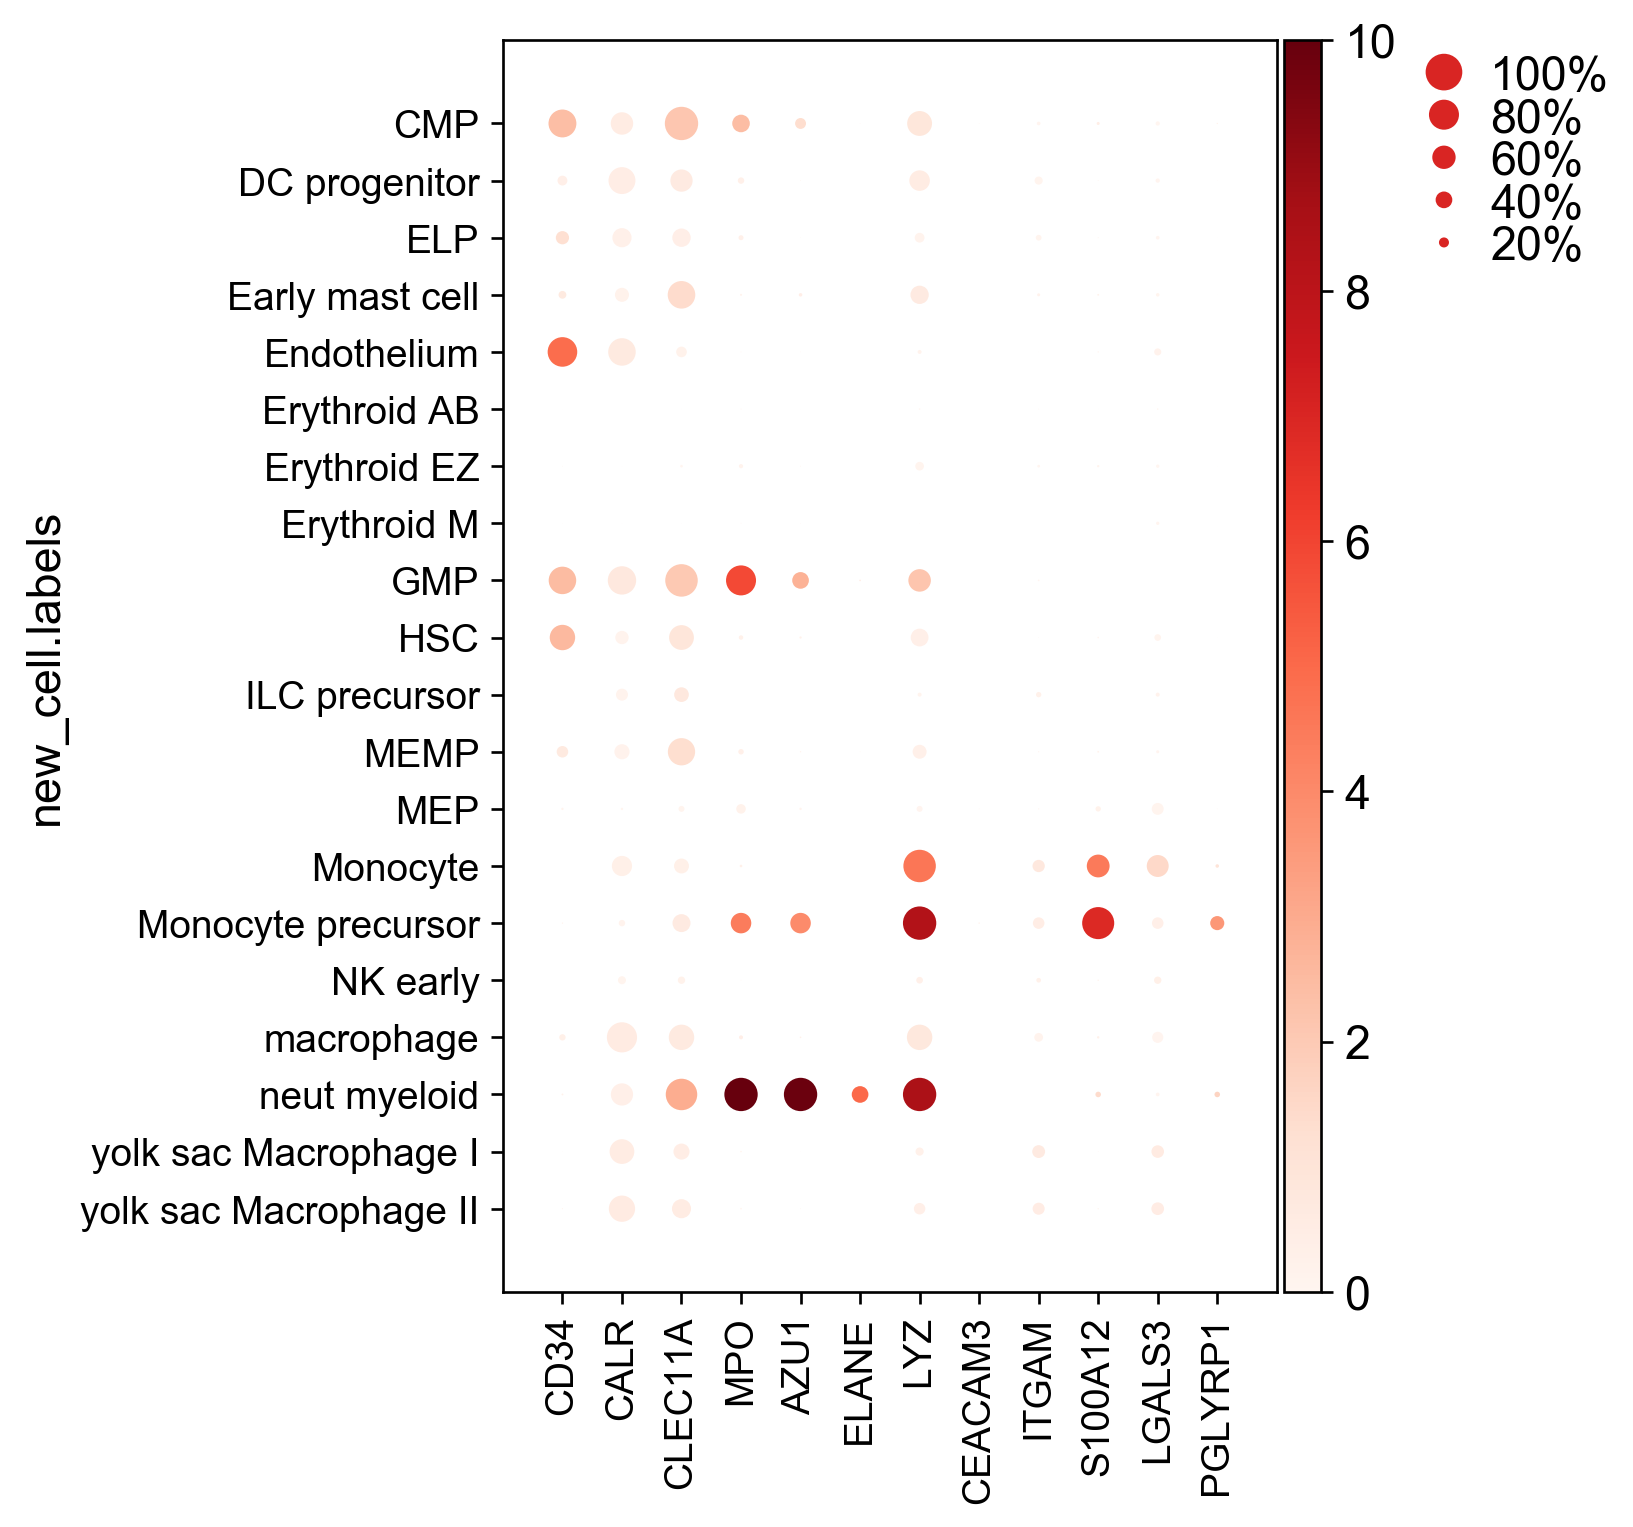

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.199999999999999, 0, 0.2, 0.5, 0.25])

In [5]:
genes = ['CD34', 'CALR', 'CLEC11A', 'MPO', 'AZU1', 'ELANE', 'LYZ', 'CEACAM3', 'ITGAM', 'S100A12', 'LGALS3', 'PGLYRP1']

sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.dotplot(adata, var_names=genes, groupby="new_cell.labels", use_raw=False, save="ys_figs2a_dotplot_20200727.pdf")

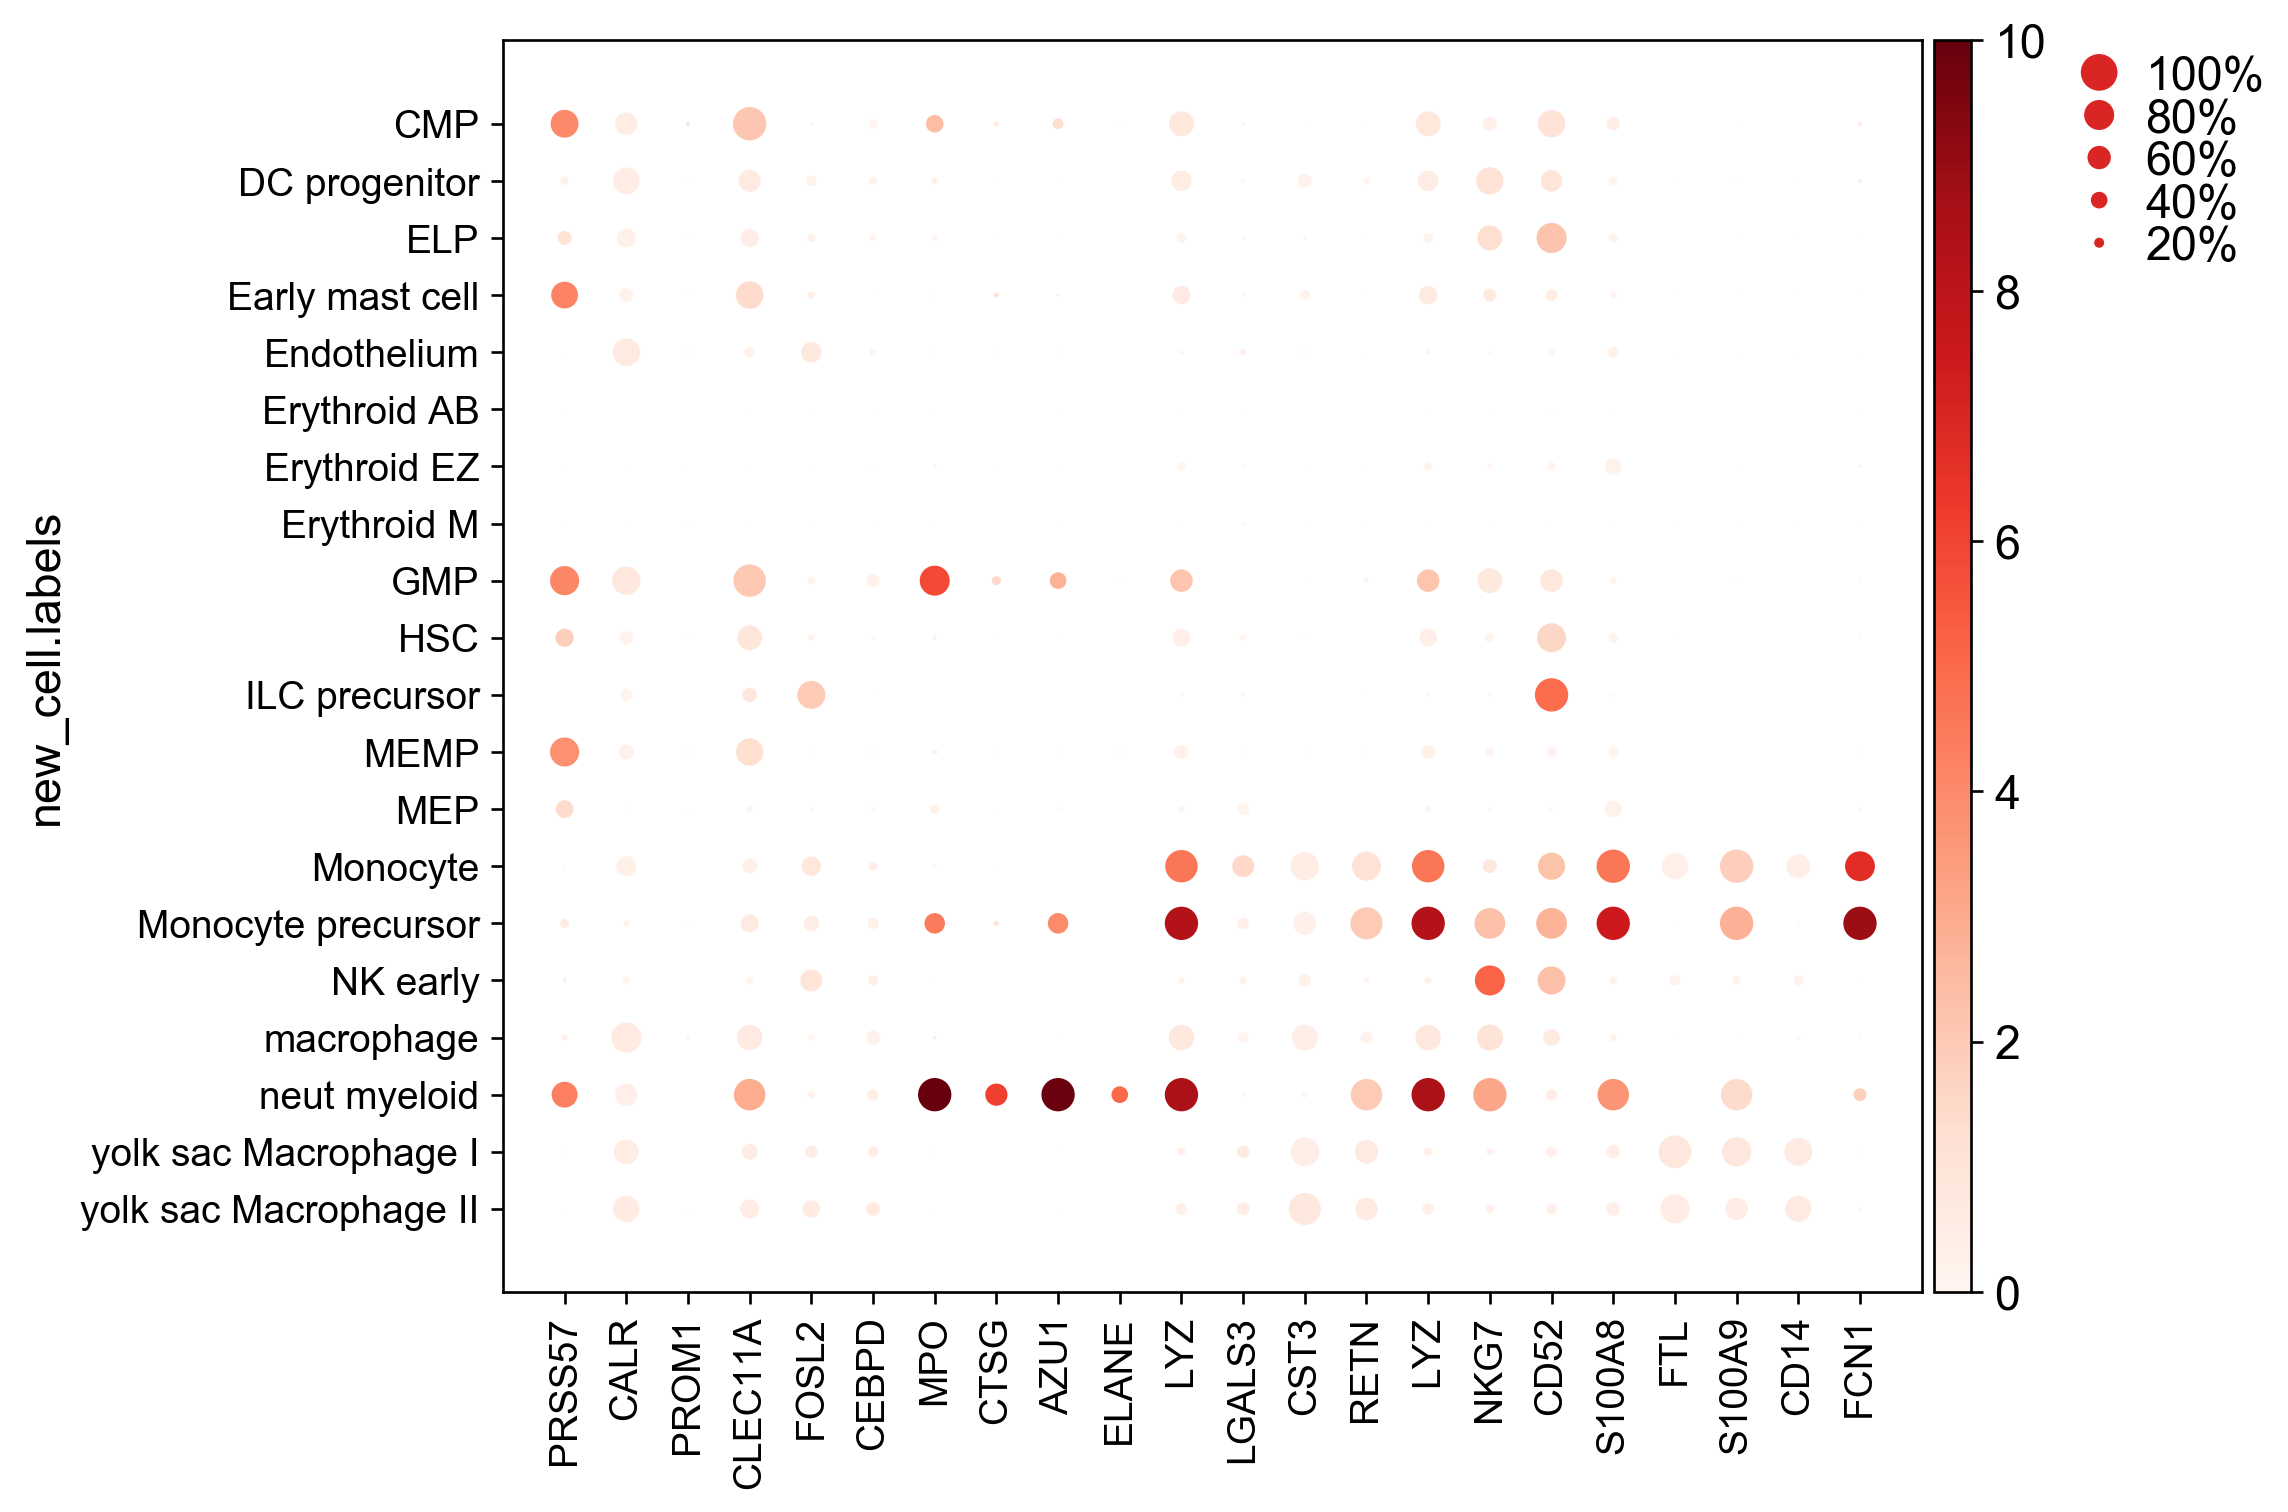

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[7.699999999999999, 0, 0.2, 0.5, 0.25])

In [6]:
genes = ['PRSS57', 'CALR', 'PROM1', 'CLEC11A', 'FOSL2', 'CEBPD', 'MPO', 'CTSG', 'AZU1', 'ELANE', 
                'LYZ', 'LGALS3', 'CST3', 'RETN', 'LYZ', 'NKG7', 'CD52',
                'S100A8', 'FTL', 'S100A9', 'CD14', 'FCN1']

sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.dotplot(adata, var_names=genes, groupby="new_cell.labels", use_raw=False, 
              save="ys_mop_dotplot_nr1_20200727.pdf")

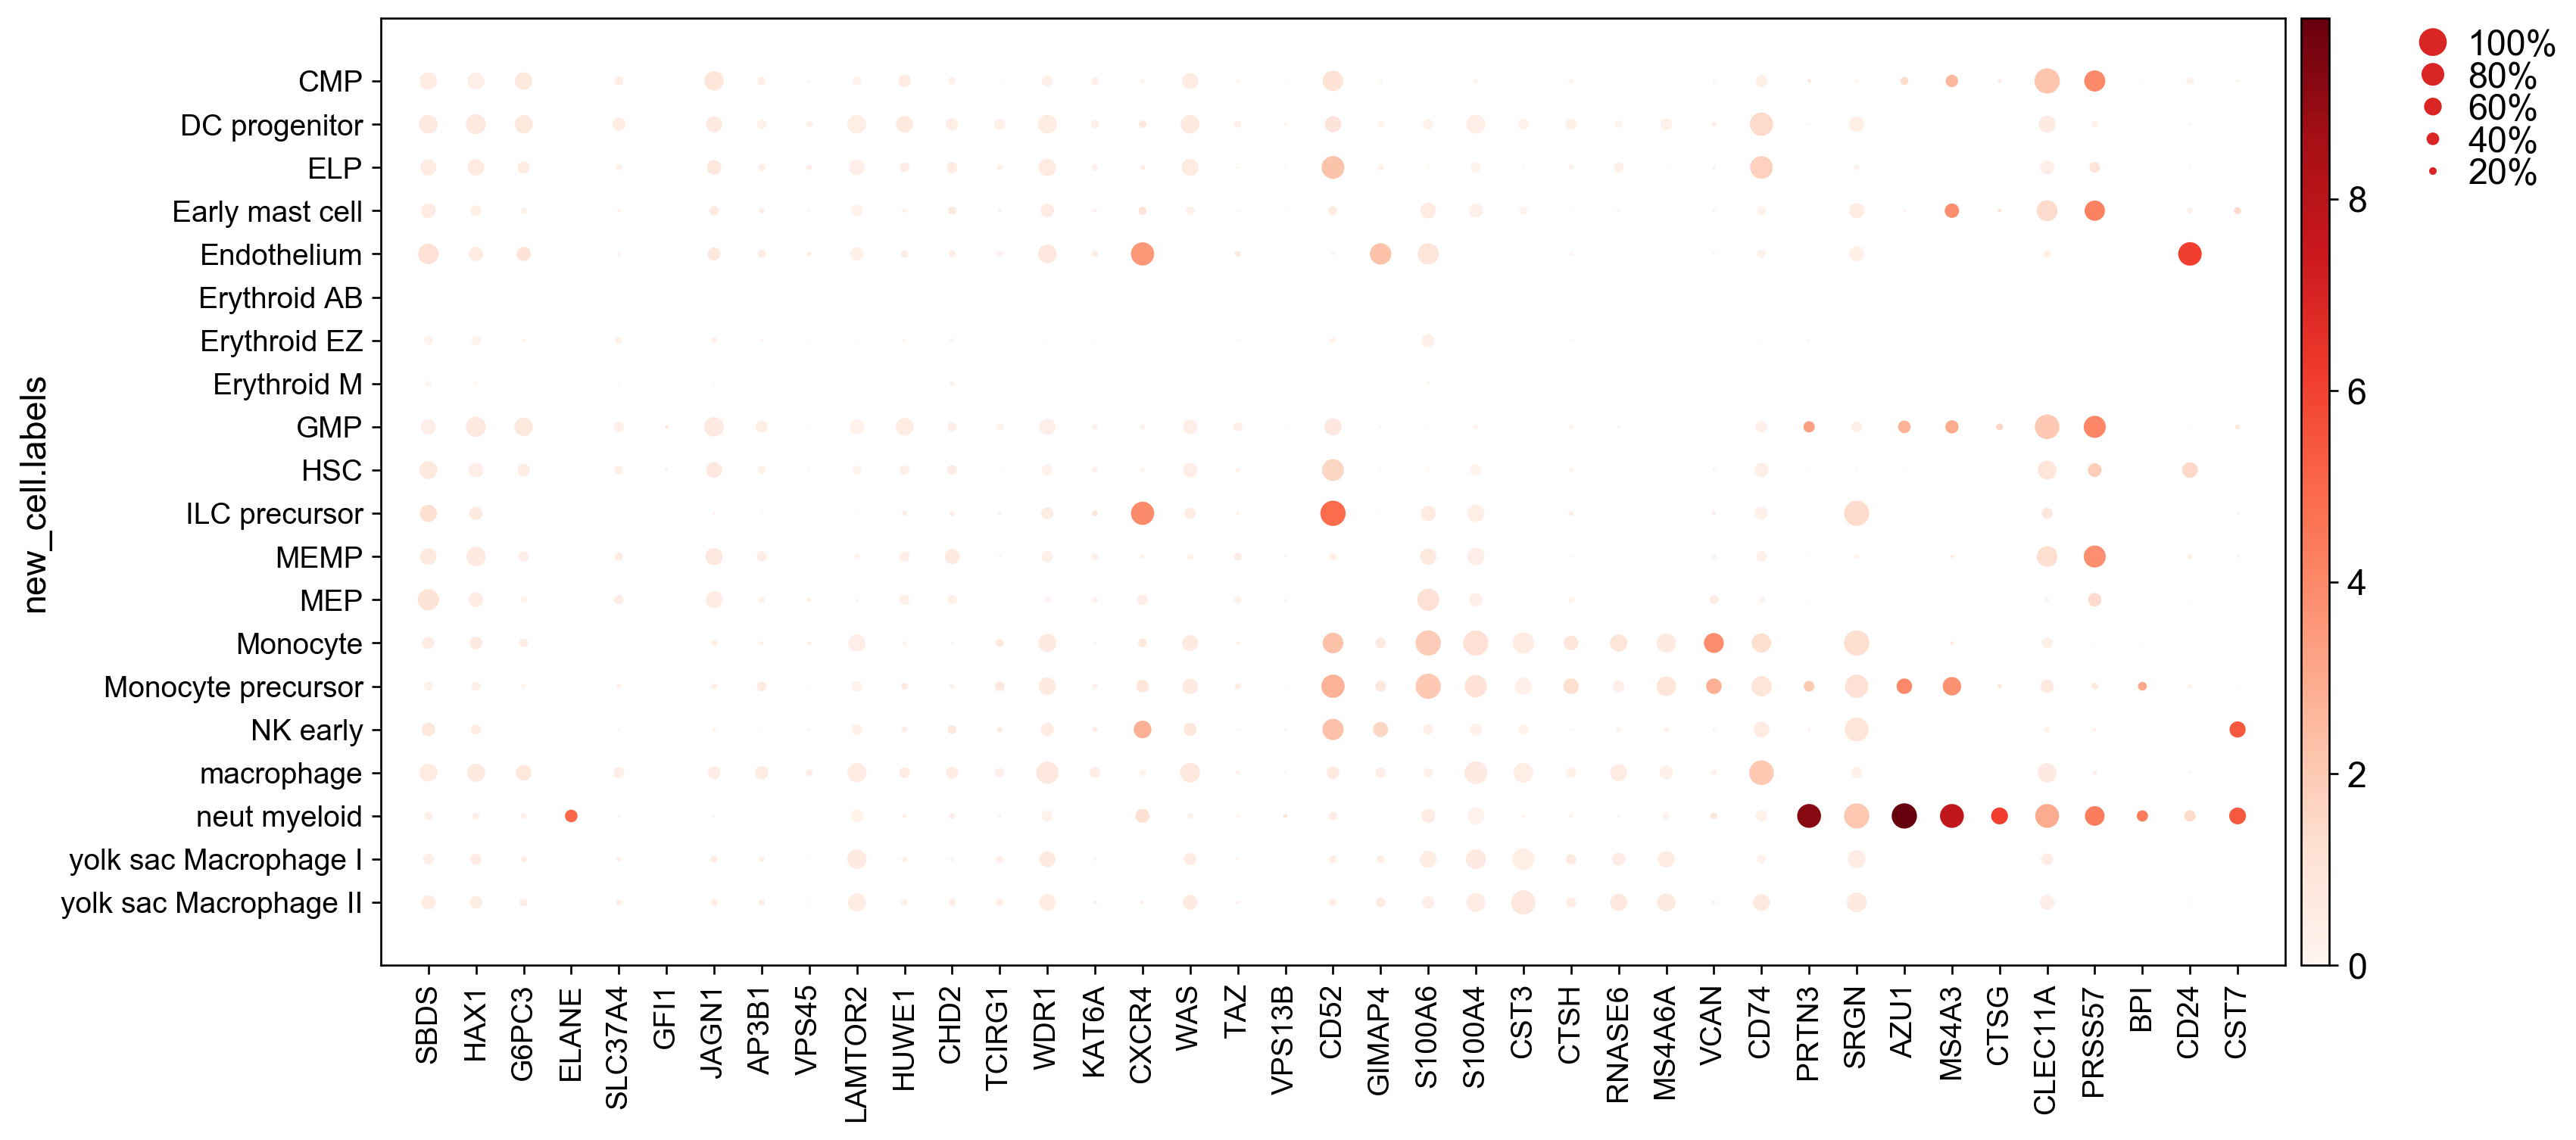

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[13.649999999999999, 0, 0.2, 0.5, 0.25])

In [7]:
genes = ['SBDS',
'HAX1',
'G6PC3',
'ELANE',
'SLC37A4',
'GFI1',
'JAGN1',
'AP3B1',
'VPS45',
'LAMTOR2',
'HUWE1',
'CHD2',
'TCIRG1',
'WDR1',
'KAT6A',
'CXCR4',
'WAS',
'TAZ',
'VPS13B', 
'CD52', # here are discrete premonocyte DEGs
'GIMAP4',
'S100A6',
'S100A4',
'CST3',
'CTSH',
'RNASE6',
'MS4A6A',
'VCAN',
'CD74',
# here are discrete promyelocyte DEGs
'PRTN3',
'SRGN',
'AZU1',
'MS4A3',
'CTSG',
'CLEC11A',
'PRSS57',
'BPI',
'CD24',
'CST7']

sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.dotplot(adata, var_names=genes, groupby="new_cell.labels", use_raw=False, 
              save="ys_mop_dotplot_nr2_20200727.pdf")